# Sentiment Based Product Recomendation System

- Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model


**Steps performed in the Notebook**
- Exploratory data analysis
- Data cleaning
- Text preprocessing
- Feature extraction
- Training a text classification model:

In [1]:
#importing libraries
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import numpy as np
import pandas as pd
from pandas import DataFrame
import calendar
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline


In [2]:
#Creating a dataframe from the provided sample ratings file
ratings = pd.read_csv('sample30.csv', encoding='windows-1252')
ratings.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
#checking information about the data
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

### EDA

In [4]:
#checking for null values in the data set
print("Amount of vallues missing in the dataframe :")
null_info = ratings.isna().sum() / len(ratings) * 100
null_info.sort_values(ascending = False).head(50).round(4)

Amount of vallues missing in the dataframe :


reviews_userProvince    99.4333
reviews_userCity        93.5700
reviews_didPurchase     46.8933
reviews_doRecommend      8.5667
reviews_title            0.6333
manufacturer             0.4700
reviews_username         0.2100
reviews_date             0.1533
user_sentiment           0.0033
id                       0.0000
brand                    0.0000
categories               0.0000
name                     0.0000
reviews_rating           0.0000
reviews_text             0.0000
dtype: float64

In [5]:
#dropping the columns where maximum number of datas missing are more than 20%
missing_val_threshold = len(ratings) * .2
ratings.dropna(thresh = missing_val_threshold, axis = 1, inplace = True)
print("% of missing values :")
print(ratings.isna().mean().round(4) * 100)

% of missing values :
id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.63
reviews_username        0.21
user_sentiment          0.00
dtype: float64


In [6]:
#checking the number of users/shoppers who actually provided their reviews
ratings['reviews_didPurchase'].value_counts()

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64

since we could not capture most of the data need to cehck ofr the null values and check for the genuine reviews

In [7]:
#replacing null values with 'null' on the reviews_didpurchase column
ratings['reviews_didPurchase'].fillna('Null', inplace=True)


In [8]:
ratings['reviews_didPurchase'].value_counts()

False    14498
Null     14068
True      1434
Name: reviews_didPurchase, dtype: int64

In [9]:
# doing the same for column 'reviews_doRecommend'
# replacing all the null values in the reviews_doRecommend to 'null'
ratings['reviews_doRecommend'].fillna('Null', inplace=True)

In [10]:
#checking the numbers of users doRecomend the product
ratings['reviews_doRecommend'].value_counts()

True     25880
Null      2570
False     1550
Name: reviews_doRecommend, dtype: int64

**Checking the 10 products/brands for each category**

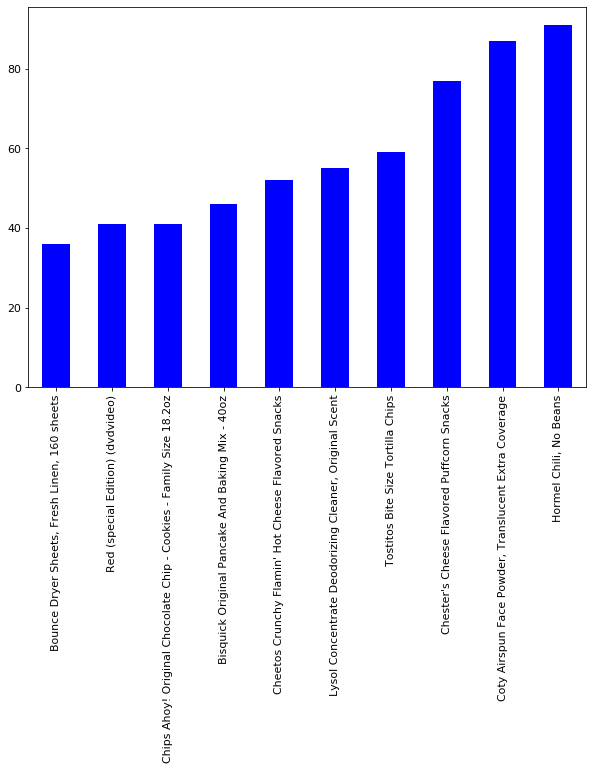

In [11]:
#checking the top 10 most purchased products in the platform
result = ratings[ratings['reviews_didPurchase'] == True]

result['name'].value_counts()[0:10].plot(kind = 'bar', figsize=[10,7], fontsize=11,color='blue').invert_xaxis()

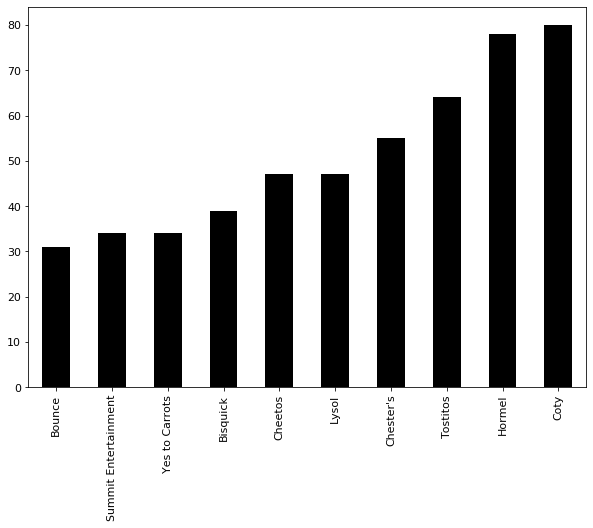

In [12]:
#accordingly checking the top 10 most purchased brands based on the positive review
from matplotlib import cm
result = ratings[(ratings['reviews_didPurchase'] == True) & (ratings.user_sentiment=="Positive")]
result['brand'].value_counts()[0:10].plot(kind = 'bar', figsize=[10,7], fontsize=11,color='black').invert_xaxis()

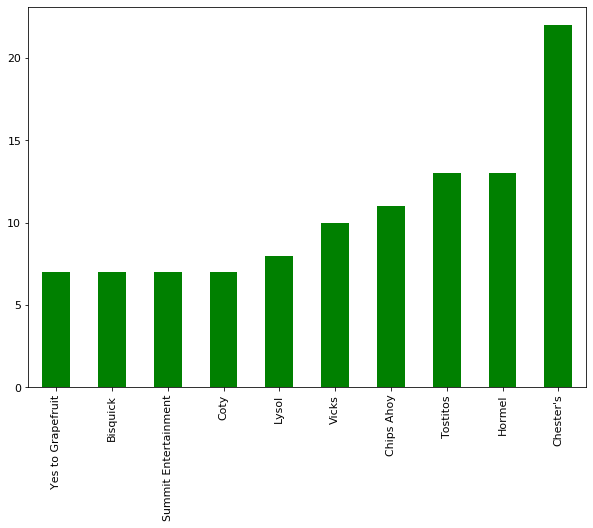

In [13]:
#similarlly checking for worst 10 rated brands based on the negative review
from matplotlib import cm
result = ratings[(ratings['reviews_didPurchase'] == True) & (ratings.user_sentiment=="Negative")]
result['brand'].value_counts()[0:10].plot(kind = 'bar', figsize=[10,7], fontsize=11,color='green').invert_xaxis()

from the above data we concur that **Coty** is leading by its products at the top whereas **Chester's** is not doing too well and has received the most negative review in the top 10 / bottom 10 products.

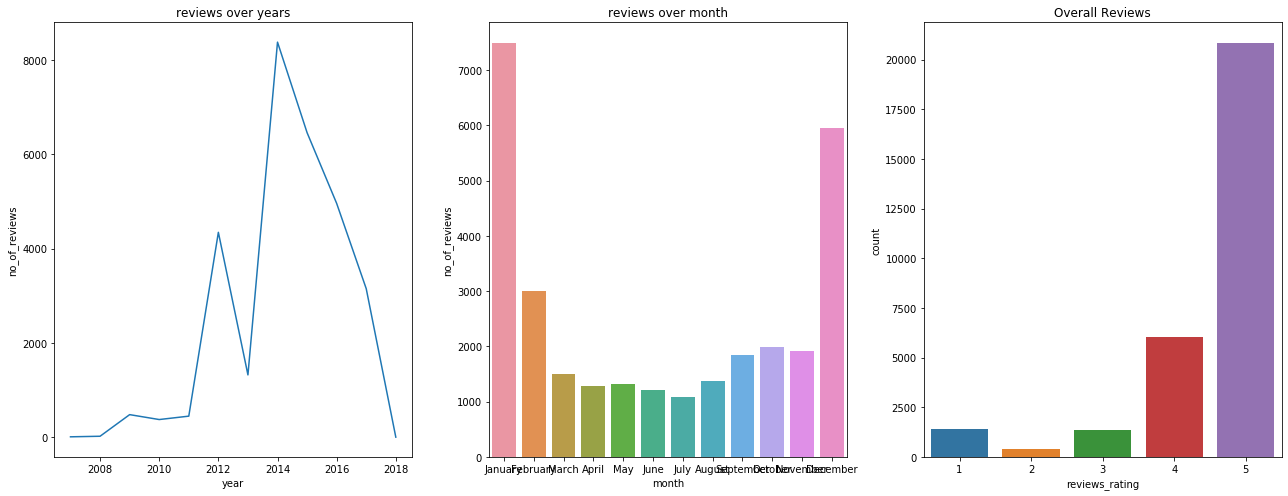

In [14]:
#splitting the dates into seperate columns
#extracting dates from the reviews_date column
ratings['reviews_onlydate'] = ratings['reviews_date'].str[:10]
ratings['reviews_onlydate'].head()

#setting the datatype for the above extracted date column
ratings['reviews_onlydate'] = pd.to_datetime(ratings['reviews_onlydate'], errors='coerce').dt.date
ratings['reviews_onlydate'].fillna(ratings['reviews_onlydate'].value_counts().idxmax(),inplace=True)
ratings['reviews_onlydate'] = pd.to_datetime(ratings.reviews_onlydate, format='%Y-%m-%d')
ratings['reviews_onlydate'].head()

#splitting date into seperate column: date, month & year
ratings['year'] = ratings['reviews_onlydate'].dt.year
ratings['month'] = ratings['reviews_onlydate'].dt.month
f, axes = plt.subplots(1,3, figsize=(18,7))

#yearly reviews
yearly = ratings.groupby(['year'])['reviews_username'].count().reset_index()
yearly = yearly.rename(columns={'reviews_username':'no_of_reviews'})
yearChart = sns.lineplot(x='year',y='no_of_reviews',data=yearly, ax = axes[0])
yearChart.set_title('reviews over years')

#monthly reviews
monthly = ratings.groupby(['month'])['reviews_username'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'reviews_username':'no_of_reviews'})
monthChart = sns.barplot(x='month',y='no_of_reviews',data=monthly, ax = axes[1])
monthChart.set_title('reviews over month')

#getting overall ratings for all products
sns.countplot(x = 'reviews_rating', data = ratings, ax = axes[2] ).set_title('Overall Reviews')

f.tight_layout()

- As we can see, there is a significant increase in number of ratings given by users from 2013 to 2015.
- After from 2016 there is sharp decrease in receiving ratings for the purchase done on the platform.
- Reviews received was high during December and January.
- Many users have given a rating of 5 to products followed by 4, 3 and 1 whereas very few users have given a low rating of 2.

In [15]:
#ratings distribution with product id
df_ratings=pd.DataFrame(ratings.groupby('id')['reviews_rating'].mean())
df_ratings['Number_Of_Ratings']=pd.DataFrame(ratings.groupby('id')['reviews_rating'].count())
df_ratings.head()

,reviews_rating,Number_Of_Ratings
id,,
AV13O1A8GV-KLJ3akUyj,5.000000,1
AV14LG0R-jtxr-f38QfS,5.000000,2
AV16khLE-jtxr-f38VFn,2.518519,27
AV1YGDqsGV-KLJ3adc-O,4.129310,348
AV1YIch7GV-KLJ3addeG,5.000000,1


**now checking the description of ratings.**

In [16]:
ratings.describe()

,reviews_rating,year,month
count,30000.000000,30000.000000,30000.000000
mean,4.483133,2014.341967,6.156433
std,0.988441,1.766728,4.366623
min,1.000000,2007.000000,1.000000
25%,4.000000,2014.000000,1.000000
50%,5.000000,2014.000000,6.000000
75%,5.000000,2016.000000,11.000000
max,5.000000,2018.000000,12.000000


### Data Preprocessing

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist
from nltk.tokenize import word_tokenize
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adash\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
#checking for the dulicate usernme and user ID
duplicates = ratings[ratings.duplicated(subset={"reviews_username","id"})]
duplicates.reviews_username.value_counts()

byamazon customer    39
mike                 24
chris                19
tony                  7
movielover            6
                     ..
kayet19               1
spidysgirl            1
gissela               1
dkane514              1
filo123               1
Name: reviews_username, Length: 2116, dtype: int64

- we see that there are multiple duplicate entries
- as the users might have bought the same items
- or the same users might have shopped again and again
- we will keep them for now, later we will remove them after checking the average

In [19]:
# checking the avegrage ratings for the dataframe
ratings['avg_ratings'] = ratings.groupby(['id','reviews_username'])['reviews_rating'].transform('mean')
ratings['avg_ratings']=ratings['avg_ratings'].round(2)
ratings[['id','reviews_username','reviews_rating','avg_ratings']]

,id,reviews_username,reviews_rating,avg_ratings
0,AV13O1A8GV-KLJ3akUyj,joshua,5,5.0
1,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
2,AV14LG0R-jtxr-f38QfS,dorothy w,5,5.0
3,AV16khLE-jtxr-f38VFn,rebecca,1,1.0
4,AV16khLE-jtxr-f38VFn,walker557,1,1.0
...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,laurasnchz,5,5.0
29996,AVpfW8y_LJeJML437ySW,scarlepadilla,5,5.0
29997,AVpfW8y_LJeJML437ySW,liviasuexo,5,5.0
29998,AVpfW8y_LJeJML437ySW,ktreed95,5,5.0


In [24]:
# checking for the rating's mean with the initial dataset
ratings["avg_ratings"].mean()

4.48411731302402

In [21]:
# removing all the duplicates entry, which has the same username and item ID
ratingsfinal =  ratings.drop_duplicates(subset={"reviews_username","id"},keep="first")

In [23]:
# now checking for the mean again after removing the duplicates
ratingsfinal["avg_ratings"].mean()

4.522550384225026

- reviews are in the form of textual form, need to clean the data and remove the stopwordsfrom the data to know the usefull info.
- combining reviews_text and reviews_title as both of them gives significant sentiment analysis.

In [25]:
#concatenating user_title and user_text
#filling missing values in reviews_title with blank space
ratingsfinal['reviews_title'] = ratingsfinal['reviews_title'].fillna('')
ratingsfinal['user_reviews'] = ratingsfinal[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')
ratingsfinal[['reviews_title','reviews_text','user_reviews']]

,reviews_title,reviews_text,user_reviews
0,Just Awesome,i love this album. it's very good. more to the...,Just Awesome. i love this album. it's very goo...
1,Good,Good flavor. This review was collected as part...,Good. Good flavor. This review was collected a...
3,Disappointed,I read through the reviews on here before look...,Disappointed. I read through the reviews on he...
4,Irritation,My husband bought this gel for us. The gel cau...,Irritation. My husband bought this gel for us....
5,Not worth it,My boyfriend and I bought this to spice things...,Not worth it. My boyfriend and I bought this t...
...,...,...,...
29995,Softness!!,I got this conditioner with Influenster to try...,Softness!!. I got this conditioner with Influe...
29996,I love it,"I love it , I received this for review purpose...","I love it. I love it , I received this for rev..."
29997,Hair is so smooth after use,First of all I love the smell of this product....,Hair is so smooth after use. First of all I lo...
29998,Perfect for my oily hair!,I received this through Influenster and will n...,Perfect for my oily hair!. I received this thr...


**now we will start defining the functions for cleaning the data, by removing all the unrequired texts**

In [26]:
#defining functions to remove the unwanted texts

#function to remove html tags
import re
def html(data):
    p = re.compile('<.*?>')
    return p.sub('',data)

#function to remove punctuations
def punc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)



In [28]:
#stopwords removal
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = stopwords.words('english')
from nltk.stem import SnowballStemmer

#initialising the snowball stemmer
snow = SnowballStemmer('english')

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [29]:
#tokenizing the sentence and findingPOS tag for each token
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(snow.stem(word))
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [32]:
#pre-processing output for one Review
def preprocessText(text, stem=False):
  text=text.lower()
  text = html(text)
  text = punc(text)
  return lemmatize_sentence(text)


In [33]:
#creating a copy of the dataset
ratings_main = ratingsfinal.copy(deep = True)
ratings_main['Review'] = ratings_main['user_reviews'].map(preprocessText)
ratings_main.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_onlydate,year,month,avg_ratings,user_reviews,Review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,Null,Null,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,2012-11-30,2012,11,5.0,Just Awesome. i love this album. it's very goo...,just awesome i love this album it very good mo...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,Null,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,2017-07-09,2017,7,5.0,Good. Good flavor. This review was collected a...,good good flavor this review be collect as par...
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,2016-01-06,2016,1,1.0,Disappointed. I read through the reviews on he...,disappointed i read through the review on here...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,2016-12-21,2016,12,1.0,Irritation. My husband bought this gel for us....,irritation my husband buy this gel for us the ...
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,2016-04-20,2016,4,1.0,Not worth it. My boyfriend and I bought this t...,not worth it my boyfriend and i buy this to sp...


### Sentiment Analysis

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [36]:
#droping unnecessary columns
ratings_main=ratings_main[['Review','reviews_rating','user_sentiment']]
data=ratings_main
ratings_main

,Review,reviews_rating,user_sentiment
0,just awesome i love this album it very good mo...,5,Positive
1,good good flavor this review be collect as par...,5,Positive
3,disappointed i read through the review on here...,1,Negative
4,irritation my husband buy this gel for us the ...,1,Negative
5,not worth it my boyfriend and i buy this to sp...,1,Negative
...,...,...,...
29995,softness i get this conditioner with influenst...,5,Positive
29996,i love it i love it i receive this for review ...,5,Positive
29997,hair be so smooth after use first of all i lov...,5,Positive
29998,perfect for my oily hair i receive this throug...,5,Positive


In [37]:
# checking the missing value in the column user sentiment
data[data['user_sentiment'].isna()]

,Review,reviews_rating,user_sentiment


In [38]:
#savinf the data
import pickle as pickle
pickle.dump(data, open("data.pkl","wb"))

In [39]:
import pickle
from pathlib import Path
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(data['Review'])
X = tfidf_vectorizer.transform(data['Review'])
y = data['user_sentiment']

# Saving vocabulary used in tfidf vectorizer as features
pickle.dump(tfidf_vectorizer.vocabulary_, open("features.pkl","wb"))

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [40]:
#checking class imbalance check
data.groupby(['user_sentiment']).count()

,Review,reviews_rating
user_sentiment,,
Negative,3058,3058
Positive,24547,24547


- this shows that there is imbalanced training data set, that will definitely affect the accuracy of the predictions. 
- to make this argument valid we need to predict negative and positive reviews by splitting the judged training data.
- then we will compare the predicted labels with the users review.

**dealing with the class imbalances**

In [41]:
#using SMOT to deal with the class imbalance
from collections import Counter
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print("Before", counter)

#oversampling using SMOTE
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print("After", counter)

Before Counter({'Positive': 18416, 'Negative': 2287})
After Counter({'Positive': 18416, 'Negative': 18416})


In [42]:
#creating process for creating confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
def display_score(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    plot_confusion_matrix(classifier, X_test, y_test,include_values=True,values_format='g',cmap=plt.cm.Blues) 
    print(classifier)
    print('\n')
    print('Accuracy is ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity is {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity is {}'.format(cm[0][0]/sum(cm[0])))

### Model rendering

In [43]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import pickle

**Random Forest - Model1**

In [51]:
#applying random forest classifier without any hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

RandomForestClassifier()


Accuracy is  0.8894523326572008
Sensitivity is 0.9848311857771979
Specificity is 0.1309987029831388


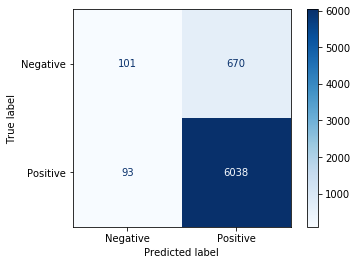

In [52]:
#displaying the score
display_score(rf)

In [53]:
#fitting a random forest classifier with diffrent hyperparameters
#created the parameter grid as per the results of random search 
param_grid = {
    'max_depth': [15, 20],
    'min_samples_leaf': [100,200],
    'min_samples_split': [200,400],
    'n_estimators': [100, 300]
}

# Create a based model
final_rf = RandomForestClassifier()

# Instantiate the grid search model
rf_tuned = GridSearchCV(estimator = final_rf, param_grid = param_grid, scoring='roc_auc', cv = 3, n_jobs = -1,verbose = 1)
rf_tuned.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

In [54]:
# print best hyperparameters
print("Best AUC-ROC Score on train data: ", rf_tuned.best_score_)
print("Best hyperparameters: ", rf_tuned.best_params_)

Best AUC-ROC Score on train data:  0.8617457261633739
Best hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 100, 'min_samples_split': 400, 'n_estimators': 100}


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)


Accuracy is  0.7845552013909012
Sensitivity is 0.8368944707225575
Specificity is 0.36835278858625164


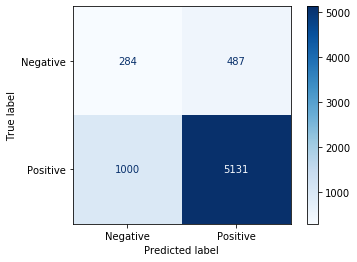

In [55]:
#test data performance metrics
display_score(rf_tuned)

**Logestic Regression - Model 2**

In [45]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train_sm, y_train_sm)
    cm = confusion_matrix(y_test, lr.predict(X_test))
    print('Sensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
    print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))

Sensitivity for C = 0.01 is 0.816832490621432
Specificity for C = 0.01 is 0.7509727626459144
Sensitivity for C = 0.05 is 0.8390148426031643
Specificity for C = 0.05 is 0.754863813229572
Sensitivity for C = 0.25 is 0.8819115968031316
Specificity for C = 0.25 is 0.7367055771725033
Sensitivity for C = 0.5 is 0.9005056271407601
Specificity for C = 0.5 is 0.7094682230869002
Sensitivity for C = 1 is 0.9176317077148916
Specificity for C = 1 is 0.6705577172503242


In [46]:
final_lr = LogisticRegression(C=0.05)
final_lr.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.05)

LogisticRegression(C=0.05)


Accuracy is  0.8296146044624746
Sensitivity is 0.8390148426031643
Specificity is 0.754863813229572


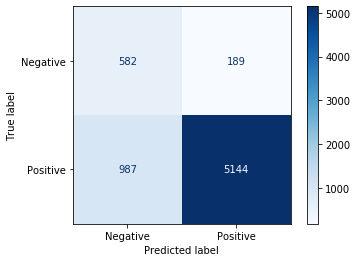

In [47]:
#displayig the score
display_score(final_lr)

In [48]:
pickle.dump(final_lr, open('final_lr.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf.pkl", "wb"))

In [49]:
tfs=pd.read_pickle('tfidf.pkl')
mdl=pd.read_pickle('final_lr.pkl')

In [50]:
feature_to_coef = {
    word: coef for word, coef in zip(
     tfidf_vectorizer.get_feature_names(), final_lr.coef_[0])
}

print('Positive Words')
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:10]:
    print(best_positive)
    
print('Negative Words')
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:10]:
    print(best_negative)

Positive Words
('great', 4.3133796189201465)
('love', 3.192852640935941)
('clean', 2.6772625592592196)
('good', 2.474104181625305)
('easy', 2.0898590285463103)
('and', 1.9950109730651588)
('best', 1.8773730829535276)
('be great', 1.5256694507228188)
('easy to', 1.497667322288093)
('really', 1.3217460903960152)
Negative Words
('bad', -2.1856403474338855)
('not', -1.495237108745758)
('evil', -1.4512628419110762)
('like', -1.3836225279284888)
('resident evil', -1.3136776986569603)
('resident', -1.2931244753599234)
('formula', -1.2513918449931474)
('horrible', -1.2418552966519087)
('disappointed', -0.9680901667566925)
('sick', -0.9268678132183714)


**Naive Bayes- Model 3**

In [56]:
#fitting model
nb=MultinomialNB()
nb.fit(X_train_sm, y_train_sm)

MultinomialNB()

MultinomialNB()


Accuracy is  0.8606201101130108
Sensitivity is 0.8985483607894308
Specificity is 0.5590142671854734


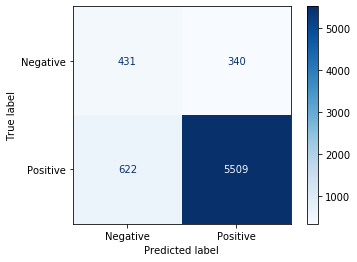

In [57]:
#test data performance metrics
display_score(nb)

### Recomendation System

- user based recommendation.
- user based prediction & evaluation.
- item based recommendation.
- item based prediction & evaluation.

In [58]:
#importing sk learn libraries to render the model and check the statistics 
from sklearn.metrics.pairwise import pairwise_distances

In [59]:
# reading the dataset 
df = pd.read_csv("sample30.csv", sep=',')
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [61]:
df = df[['id', 'reviews_rating', 'reviews_username']]


In [62]:
#checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [63]:
df = df[~df.reviews_username.isna()]
df.columns=['productId', 'rating', 'user']
df.head()

,productId,rating,user
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


**dividing the dataset into test-train set**

In [66]:
#splitting the dataset to test-train.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.30, random_state=12)
print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [67]:
# pivoting the train ratings into a matrix format, in which columns are products and the rows are user IDs.
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(0)

df_pivot.head(3)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**creating dummy train & dummy test dataset**

In [68]:
#coping the train dataset into dummy_train
dummy_train = train.copy()

dummy_train.head()

,productId,rating,user
27729,AVpfRTh1ilAPnD_xYic2,5,stevieboy23
17120,AVpf9pzn1cnluZ0-uNTM,5,byo.kelly
22028,AVpfnRuSilAPnD_xfB8l,3,linda h
16308,AVpf63aJLJeJML43F__Q,5,cocoacrazy
19457,AVpfJP1C1cnluZ0-e3Xy,5,vanessavast


In [69]:
#the products which are not rated by user is marked as 1 for prediction. 
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [70]:
#convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).fillna(1)


dummy_train.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Using similarity matrix**

In [71]:
df_pivot.index.nunique()

18188

In [72]:
#creating user similarity matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [73]:
user_correlation.shape

(18188, 18188)

In [74]:
#using adjusted cosine
#creating a user-product matrix.
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
)

In [75]:
df_pivot.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
#normalising the rating for each user around 0 mean
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
#finding cosign similarity

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [78]:
user_correlation.shape

(18188, 18188)

### User-User Prediction

- doing the prediction for the users which are positively related with other users
- we will not predict for users which are negatively related as we are interested in the users which are more similar to the current users

In [79]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
#rating predicted by user
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [81]:
user_predicted_ratings.shape

(18188, 251)

In [82]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.93649167,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [84]:
#will check only the products which are not predicted by the users, so making the products rated by user as zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()


productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [85]:
user_final_rating

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
zyiah4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [89]:
#taking the user ID as input.

user_input='zyiah4'
print(user_input)

zyiah4


In [90]:
user_final_rating.head(10)

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.000000,0.000000,0.0,0.0,0.749669,0.0,0.944911,0.0,0.0,...,0.0,0.0,0.0,1.597933,0.0,0.0,0.0,0.0,1.936492,0.204124
01impala,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02dakota,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
08dallas,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1.11E+24,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
10ten,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
11111111aaaaaaaaaaaaaaaaa,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [91]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AV14LG0R-jtxr-f38QfS    0.0
AVpfPPkEilAPnD_xX3cP    0.0
AVpfN6Z71cnluZ0-gZmO    0.0
AVpfNVsj1cnluZ0-gNQN    0.0
AVpfNWbPilAPnD_xXPR7    0.0
AVpfNc9cLJeJML434tza    0.0
AVpfNfEMLJeJML434uf-    0.0
AVpfNglu1cnluZ0-gQ7x    0.0
AVpfO5u71cnluZ0-guiN    0.0
AVpfOIrkilAPnD_xXgDG    0.0
AVpfOfIqLJeJML435D06    0.0
AVpfOmKwLJeJML435GM7    0.0
AVpfOrD0ilAPnD_xXrRj    0.0
AVpfP-rELJeJML435jEN    0.0
AVpfPKzxLJeJML435SYL    0.0
AVpfPaoqLJeJML435Xk9    0.0
AVpfSvmGilAPnD_xY_gE    0.0
AVpfPjqKLJeJML435aZR    0.0
AVpfPkrkilAPnD_xX-L9    0.0
AVpfPnrU1cnluZ0-g9rL    0.0
Name: zyiah4, dtype: float64

**evaluation for user-user prediction model**

taking transpose of rating matrix to normalize the rating around mean for different product Id s in the user based similarity, considered mean for each user instead of each products.

In [92]:
df_pivot = train.pivot_table(
    index='user',
    columns='productId',
    values='rating'
).T

df_pivot.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
#normalising the products rating for each products for using the adujsted cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

user,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,1.11E+24,10ten,11111111aaaaaaaaaaaaaaaaa,1234,...,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zyiah4,zzdiane,zzz1127
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
from sklearn.metrics.pairwise import pairwise_distances

# item similarity matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)
print(item_correlation.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(251, 251)


In [95]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction Item-Item

In [96]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00666715, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00693369],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00554695]])

In [97]:
item_predicted_ratings.shape

(18188, 251)

In [98]:
dummy_train.shape

(18188, 251)

In [99]:
#finding the rating for only productds for which review has not been provided
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

productId,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.006364,0.0,0.000000,...,0.0,0.014313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.006667,0.0,0.0,0.0,0.0,0.004563,0.000000,0.0,0.000896,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.011112,0.0,0.0,0.0,0.0,0.007606,0.000000,0.0,0.001493,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.008890,0.0,0.0,0.0,0.0,0.006084,0.000000,0.0,0.001195,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**top 20 recomendations for the users**

In [100]:
#take the user id as input
user_input='00dog3'
print(user_input)

00dog3


In [101]:
#recommending the top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

productId
AVpe41TqilAPnD_xQH3d    0.047425
AVpe5s3RLJeJML43x4eA    0.036194
AVpfOmKwLJeJML435GM7    0.035717
AVpe8gsILJeJML43y6Ed    0.024162
AVpfN6Z71cnluZ0-gZmO    0.018892
AVpfAgSp1cnluZ0-b2-K    0.015928
AVpe59io1cnluZ0-ZgDU    0.014088
AVpfJP1C1cnluZ0-e3Xy    0.008025
AVpfPaoqLJeJML435Xk9    0.007972
AVpf3VOfilAPnD_xjpun    0.006288
AVpfPPkEilAPnD_xX3cP    0.000000
AVpfOIrkilAPnD_xXgDG    0.000000
AVpfOrD0ilAPnD_xXrRj    0.000000
AVpfO5u71cnluZ0-guiN    0.000000
AVpfP-rELJeJML435jEN    0.000000
AVpfPKzxLJeJML435SYL    0.000000
AVpfNglu1cnluZ0-gQ7x    0.000000
AVpfOfIqLJeJML435D06    0.000000
AV14LG0R-jtxr-f38QfS    0.000000
AVpfNc9cLJeJML434tza    0.000000
Name: 00dog3, dtype: float64

In [102]:
#saving the model
pickle.dump(user_final_rating.astype('float32'), open('user_final_rating.pkl', 'wb'))

**evalueation for the item-item prediction model**
- evaluation will we same as we have seen above for the prediction. 
- the only difference being, we will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [103]:
test.columns

Index(['productId', 'rating', 'user'], dtype='object')

In [104]:
common =  test[test.productId.isin(train.productId)]
common.shape

(8962, 3)

In [105]:
common.head(4)

,productId,rating,user
19513,AVpfJP1C1cnluZ0-e3Xy,5,kanderson927
12599,AVpf3VOfilAPnD_xjpun,5,arib
1587,AVpe31o71cnluZ0-YrSD,4,karv
15380,AVpf5FF71cnluZ0-tHAV,5,xxacw12xx


In [106]:
common_item_based_matrix = common.pivot_table(index='user', columns='productId', values='rating').T

In [107]:
common_item_based_matrix.shape

(199, 8383)

In [108]:
item_correlation_df = pd.DataFrame(item_correlation)

In [109]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
item_correlation_df['productId'] = df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
list_name = common.productId.tolist()

In [112]:
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [113]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [114]:
item_correlation_df_3.head()

,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037657,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.066184,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
item_correlation_df_3[item_correlation_df_3<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07508529, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00693369, 0.00693369, 0.01091379, ..., 0.        , 0.00693369,
        0.00277348]])

In [116]:
common_item_predicted_ratings.shape

(199, 8383)

In [117]:
dummy_test = common.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='user', columns='productId', values='rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

- productions not reviewed is marked as 0 for evaluation
- making the item item matrix representation

In [118]:
common_ = common.pivot_table(index='user', columns='productId', values='rating').T

In [119]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [120]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [121]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5457902087431066
